In [1047]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
import pandas_datareader.data as web
import string
import nltk
from nltk.tokenize import MWETokenizer  #import tokenizer
nltk.download('stopwords')  #download the list of stopwords, if you have not already done so
from nltk.corpus import stopwords  #import the list of stopwords
from nltk.stem.snowball import SnowballStemmer  #import stemmer module
import ta
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiaoming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1164]:
zoom=pd.read_csv('/Users/xiaoming/computational/ZM_clean.csv')

In [1049]:
zoom.head()

,date,time,tweet
0,2020-04-25,16:37:25,Happy to report these puts went to 0 and I did...
1,2020-04-25,16:36:41,Actual footage of me trying to get rid of my b...
2,2020-04-25,16:35:03,Most active options Friday- $AAPL $INTC $BYND ...
3,2020-04-25,16:34:15,$KR chart taking advantage of the situation an...
4,2020-04-25,16:33:05,"Icahn says stocks are overvalued... $ZM, $CODX..."


# Clean Data and sentiment score

In [910]:
def negation_handling (text):
    negatereg1=re.compile(r'n’t \S*')
    negatereg2=re.compile(r'no \S*')
    negatereg3=re.compile(r'not \S*')
    
    negate_list1=negatereg1.findall(i)
    negate_list2=negatereg2.findall(i)
    negate_list3=negatereg3.findall(i)
    negate_list = negate_list1 + negate_list2 + negate_list3

    text1 = re.sub(negatereg1,'', text) 
    text2 = re.sub(negatereg2,'', text1) 
    text3 = re.sub(negatereg3,'', text2) 
    
    return text3, negate_list

In [911]:
def clean_tokenize (text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    text_nonum = text_nonum.replace('”', '')
    text_nonum = text_nonum.replace('“', '')
    text_nonum = text_nonum.replace('—', ' ')
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace. Also, removes leading and trailing whitespaces
    text_cleaned = re.sub('\s+', ' ', text_nopunct).strip()
    text_output = tokenizer.tokenize(text_cleaned.split())
    text_stopwords = []
    for word in text_output:
        if word not in stopwords.words('english'):  #filter the stop words
            text_stopwords.append(word) 
    text_stemmed = ([stemmer.stem(w) for w in text_stopwords])
    return text_stemmed
stemmer = SnowballStemmer('english')

In [912]:
df1 = pd.read_excel('/Users/xiaoming/Desktop/computational FIN/LM Sentiment Dictionary.xlsx', sheet_name='Positive') # if using spyder 3.7+, change sheetname to sheet_name
positive_temp = df1['WORD'].tolist()
positive = [item.lower() for item in positive_temp]
positive_stemmed = ([stemmer.stem(w) for w in positive])
positive_negate = []
for word in positive_stemmed:
    positive_negate.append('n’t '+ word)
    positive_negate.append('no '+ word)
    positive_negate.append('not '+ word)

df2 = pd.read_excel('/Users/xiaoming/Desktop/computational FIN/LM Sentiment Dictionary.xlsx', sheet_name='Negative') # if using spyder 3.7+, change sheetname to sheet_name
negative_temp = df2['WORD'].tolist()
negative = [item.lower() for item in negative_temp]
negative_stemmed = ([stemmer.stem(w) for w in negative])
negative_negate = []
for word in negative_stemmed:
    negative_negate.append('n’t '+ word)
    negative_negate.append('no '+ word)
    negative_negate.append('not '+ word)

positive_final = positive_stemmed + negative_negate
negative_final = negative_stemmed + positive_negate
stemmer = SnowballStemmer('english')
tokenizer = MWETokenizer([('new', 'york'), ('san', 'francisco')])

In [913]:
abc=[]
for i in zoom['tweet']:
    
    docu_negate, nlist = negation_handling(i)
    nlist_stemmed = ([stemmer.stem(w) for w in nlist])
    docu_tokens = clean_tokenize(docu_negate) 
    docufinal = docu_tokens + nlist_stemmed
    doculen = len(docufinal)
    docu_positive = ([w for w in docufinal if w in positive_final])
    docu_negative = ([w for w in docufinal if w in negative_final])
    docu_sentiment = (len(docu_positive)-len(docu_negative))/doculen
    abc.append(docu_sentiment)

In [920]:
abc=pd.DataFrame(abc)
abc

,0
0,0.125000
1,-0.023810
2,0.000000
3,0.000000
4,-0.100000
...,...
36203,-0.125000
36204,-0.083333
36205,0.000000
36206,0.000000


In [921]:
zoom = pd.concat([zoom, abc],axis=1)
zoom.columns.values[-1]='score'
zoom

,date,time,tweet,score
0,2020-04-25,16:37:25,Happy to report these puts went to 0 and I did...,0.125000
1,2020-04-25,16:36:41,Actual footage of me trying to get rid of my b...,-0.023810
2,2020-04-25,16:35:03,Most active options Friday- $AAPL $INTC $BYND ...,0.000000
3,2020-04-25,16:34:15,$KR chart taking advantage of the situation an...,0.000000
4,2020-04-25,16:33:05,"Icahn says stocks are overvalued... $ZM, $CODX...",-0.100000
...,...,...,...,...
36203,2019-07-01,07:26:32,$ZM - Zoom Video -3% as Goldman questions valu...,-0.125000
36204,2019-07-01,07:13:03,GS downgraded $ZM trend line is 85.70 area t...,-0.083333
36205,2019-07-01,07:07:50,$ZM isn't downing much. $88.....,0.000000
36206,2019-07-01,05:50:22,$ZM #15ORB. 😁👍 https://twitter.com/theflynews/...,0.000000


In [922]:
zoom=zoom[zoom['score'] != 0]

,date,time,tweet,score
36201,2019-07-01,07:35:34,$ZM didn't show up today - down 4% on Goldman ...,-0.166667
36202,2019-07-01,07:26:57,Zoom Video Downgraded To Sell From Neutral At ...,-0.076923
36203,2019-07-01,07:26:32,$ZM - Zoom Video -3% as Goldman questions valu...,-0.125000
36204,2019-07-01,07:13:03,GS downgraded $ZM trend line is 85.70 area t...,-0.083333
36207,2019-07-01,05:02:04,Zoom Video downgraded to Sell from Neutral at ...,-0.090909


In [923]:
zoom_mean=(zoom.groupby(zoom.date).mean())

zoom_mean.index.name='Date'
zoom_mean

,score
Date,
2019-07-01,-0.052642
2019-07-02,-0.036970
2019-07-03,-0.061251
2019-07-04,0.011222
2019-07-05,0.015686
...,...
2020-04-21,-0.029387
2020-04-22,-0.013261
2020-04-23,-0.011844


In [924]:
start = dt.datetime(2019, 7, 1)
end =  dt.datetime(2020, 4, 25) #dt.datetime.now() 

zoom_price = web.DataReader('ZM', 'yahoo', start, end)
zoom_price=pd.DataFrame(zoom_price)
zoom_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002
...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000


# Technical Indicator

In [925]:
ADI=ta.volume.AccDistIndexIndicator(high=zoom_price['High'], low=zoom_price['Low'], close=zoom_price['Close'], volume=zoom_price['Volume'])
zoom_price['ADI']=ADI.acc_dist_index()
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI
Date,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06
...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07


In [927]:
CMF=ta.volume.ChaikinMoneyFlowIndicator(high=zoom_price['High'], low=zoom_price['Low'], close=zoom_price['Close'], volume=zoom_price['Volume'])
zoom_price['CMF']=CMF.chaikin_money_flow() 
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF
Date,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811
...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817


In [928]:
OBV=ta.volume.OnBalanceVolumeIndicator(close=zoom_price['Close'], volume=zoom_price['Volume'])
zoom_price['OBV']=OBV.on_balance_volume() 
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV
Date,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300
...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700


In [929]:
ROC=ta.momentum.ROCIndicator(close=zoom_price['Close'], n=1)
zoom_price['ROC']=ROC.roc() 
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV,ROC
Date,,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800,NaN
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800,-1.991715
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900,6.249266
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600,1.580984
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300,-1.218976
...,...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000,-0.713043
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900,-3.839185
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700,4.871917


In [930]:
RSI = ta.momentum.RSIIndicator(close=zoom_price['Close'], n=4)
zoom_price['RSI']=RSI.rsi() 
zoom_price.iloc[0:2,-1]=0
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV,ROC,RSI
Date,,,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057


In [931]:
WR=ta.momentum.WilliamsRIndicator(high=zoom_price['High'], low=zoom_price['Low'], close=zoom_price['Close'],lbp=1)
zoom_price['WR']=WR.wr()
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV,ROC,RSI,WR
Date,,,,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000,-19.829420
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992


In [932]:
FI=ta.volume.ForceIndexIndicator(close=zoom_price['Close'], volume=zoom_price['Volume'],n=1)
zoom_price['FI']=FI.force_index()
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI
Date,,,,,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000,-19.829420,NaN
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07


In [933]:
VPT=ta.volume.VolumePriceTrendIndicator(close=zoom_price['Close'], volume=zoom_price['Volume'])
zoom_price['VPT']=VPT.volume_price_trend() 
zoom_price

,High,Low,Open,Close,Volume,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT
Date,,,,,,,,,,,,,,
2019-07-01,87.790001,83.099998,85.129997,86.860001,5326800,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000,-19.829420,NaN,-1.562896e+05
2019-07-02,86.849998,84.000000,86.269997,85.129997,1866000,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06,-2.295267e+05
2019-07-03,90.599998,84.510002,85.449997,90.449997,2706100,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05
2019-07-05,91.970001,88.000000,90.139999,91.879997,2582700,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05
2019-07-08,92.790001,89.889999,91.440002,90.760002,1793300,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,155.000000,148.253998,153.300003,148.990005,11218700,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04
2020-04-21,154.750000,138.360001,151.419998,143.270004,9709100,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05
2020-04-22,152.279999,145.100006,147.100006,150.250000,6552800,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04


In [934]:
zoom_price=zoom_price.drop(columns=['High','Low','Open','Close','Volume'], axis=1)
zoom_price

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT
Date,,,,,,,,,
2019-07-01,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000,-19.829420,NaN,-1.562896e+05
2019-07-02,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06,-2.295267e+05
2019-07-03,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05
2019-07-05,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05
2019-07-08,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04
...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04


In [1165]:
zoom_new = pd.merge(zoom_price, zoom_mean, left_index=True, right_index=True)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score
Date,,,,,,,,,,
2019-07-01,86.860001,3.214253e+06,0.603412,5326800,NaN,0.000000,-19.829420,NaN,-1.562896e+05,-0.052642
2019-07-02,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06,-2.295267e+05,-0.036970
2019-07-03,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05,-0.061251
2019-07-05,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05,0.015686
2019-07-08,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04,-0.015183
...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-0.017740
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-0.029387
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-0.013261


In [1166]:
zoom_new['ROC'][zoom_new['ROC'].isnull()]=np.mean(zoom_new['ROC'])
zoom_new

/Users/xiaoming/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score
Date,,,,,,,,,,
2019-07-01,86.860001,3.214253e+06,0.603412,5326800,0.374905,0.000000,-19.829420,NaN,-1.562896e+05,-0.052642
2019-07-02,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06,-2.295267e+05,-0.036970
2019-07-03,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05,-0.061251
2019-07-05,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05,0.015686
2019-07-08,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04,-0.015183
...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-0.017740
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-0.029387
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-0.013261


In [1167]:
zoom_new['FI'][zoom_new['FI'].isnull()]=np.mean(zoom_new['FI'])
zoom_new

/Users/xiaoming/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score
Date,,,,,,,,,,
2019-07-01,86.860001,3.214253e+06,0.603412,5326800,0.374905,0.000000,-19.829420,3.079672e+06,-1.562896e+05,-0.052642
2019-07-02,85.129997,2.827955e+06,0.393165,3460800,-1.991715,0.000000,-60.350952,-3.228186e+06,-2.295267e+05,-0.036970
2019-07-03,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05,-0.061251
2019-07-05,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05,0.015686
2019-07-08,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04,-0.015183
...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-0.017740
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-0.029387
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-0.013261


In [1168]:
zoom_new.loc[0:2,'RSI']=np.mean(zoom_new['RSI'])
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score
Date,,,,,,,,,,
2019-07-01,86.860001,3.214253e+06,0.603412,5326800,0.374905,53.116401,-19.829420,3.079672e+06,-1.562896e+05,-0.052642
2019-07-02,85.129997,2.827955e+06,0.393165,3460800,-1.991715,53.116401,-60.350952,-3.228186e+06,-2.295267e+05,-0.036970
2019-07-03,90.449997,5.400748e+06,0.545591,6166900,6.249266,80.392866,-2.463081,1.439645e+07,1.319460e+05,-0.061251
2019-07-05,91.879997,7.866344e+06,0.630235,8749600,1.580984,84.778546,-2.267102,3.693262e+06,2.099435e+05,0.015686
2019-07-08,90.760002,7.149026e+06,0.500811,6956300,-1.218976,68.725440,-69.999921,-2.008487e+06,1.897219e+04,-0.015183
...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-0.017740
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-0.029387
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-0.013261


In [1169]:
market_score=pd.read_csv('/Users/xiaoming/computational/Sentiments_Coronavirus.csv',index_col=0)
market_score

,sentiments
dates,
2020-01-01,-0.013624
2020-01-02,-0.013514
2020-01-03,-0.012000
2020-01-04,-0.002639
2020-01-05,-0.010000
...,...
2020-04-21,-0.026963
2020-04-22,-0.026032
2020-04-23,-0.019547


In [1170]:
zoom_new=pd.merge(zoom_new.iloc[128:,:], market_score, left_index=True, right_index=True)

# Lag signal and Position

In [1171]:
zoom_new['log return']=np.log(zoom_new['Adj Close']/zoom_new['Adj Close'].shift(1))
zoom_new['log return'][zoom_new['log return'].isnull()]=np.mean(zoom_new['log return'])
zoom_new['signal']=1
for i in range(len(zoom_new['log return'])-1):
    if zoom_new.iloc[i,-2]>0:
        zoom_new.iloc[i+1,-1]=1
    else:
        zoom_new.iloc[i+1,-1]=-1
zoom_new['position']=0
for i in range(len(zoom_new.loc[:,'log return'])-1):
    if zoom_new.iloc[i,-3] > 0:
        if zoom_new.iloc[i,-1] != 1:
            zoom_new.iloc[i+1,-1]=zoom_new.iloc[i,-1]+1
        else:
            zoom_new.iloc[i+1,-1]=zoom_new.iloc[i,-1]
    else:
        if zoom_new.iloc[i,-1] != -1:
            zoom_new.iloc[i+1,-1]=zoom_new.iloc[i,-1]-1
        else:
            zoom_new.iloc[i+1,-1]=zoom_new.iloc[i,-1]
zoom_new
        

/Users/xiaoming/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,sentiments,log return,signal,position
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,-0.013514,0.010739,1,0
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,-0.012000,-0.021177,1,1
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,-0.017762,0.044193,-1,0
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,-0.009259,0.022220,1,1
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,-0.034179,0.009000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,-0.025723,-0.007156,-1,-1
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,-0.026963,-0.039148,-1,-1
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,-0.026032,0.047570,-1,-1
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,-0.019547,0.118131,1,0


# Regression

In [1070]:
from sklearn.preprocessing import StandardScaler
data=zoom_new.loc[:,'ADI':'sentiments']
scaler = StandardScaler() 
scaler.fit(data)
x_std = scaler.transform(data)


In [1074]:
y=np.array(x_std[0])
x=x_std[1:].reshape(10,78)

In [1075]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

### DecisionTreeRegressor

In [1076]:
regressor = DecisionTreeRegressor(max_depth=3,random_state=0) 
cross_val_score(regressor, x_train, y_train, cv=2).mean()

-16.398286445918515

In [1077]:
regressor.fit(x_train, y_train) 
regressor.score(x_test, y_test)

-0.0020655341980877484

### RandomForestRegressor

In [1087]:
regressor = RandomForestRegressor(random_state=3)
cross_val_score(regressor, x_train, y_train, cv=3).mean()

-591394.1022744988

In [1080]:
y1=regressor.fit(x_train,y_train)
y2=regressor.predict(x_test)

# Classification

### Train_test_split

In [1190]:
y=zoom_new.iloc[:,-2]
x=x_std
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

### DecisionTreeClassifier

In [1099]:
clf = DecisionTreeClassifier(min_samples_leaf=1 ,max_depth=2,random_state=25,splitter='best',criterion='gini')
clf.fit(x_train, y_train) 
clf.score(x_test, y_test)

0.75

In [1100]:
clf_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
print(clf_score)

0.8433333333333334


In [1172]:
zoom_new['Decisiontreecla']=clf.predict(x_std)
zoom_new['Decisiontreecla return']=1
for i in range(len(zoom_new['Decisiontreecla return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,sentiments,log return,signal,position,Decisiontreecla,Decisiontreecla return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,-0.013514,0.010739,1,0,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,-0.012000,-0.021177,1,1,1,0.989334
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,-0.017762,0.044193,-1,0,1,1.033056
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,-0.009259,0.022220,1,1,1,1.056010
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,-0.034179,0.009000,1,1,1,1.065514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,-0.025723,-0.007156,-1,-1,-1,4.203794
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,-0.026963,-0.039148,-1,-1,-1,4.368365
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,-0.026032,0.047570,-1,-1,-1,4.160563
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,-0.019547,0.118131,1,0,1,4.652053


#### Gridsearch 

In [1093]:
import numpy as np 
gini_thresholds = np.linspace(0,0.5,20)
parameters = {'splitter':('best','random')

            ,'criterion':("gini","entropy") 
              ,"max_depth":[*range(1,6)] 
              ,'min_samples_leaf':[*range(1,50,5)] }

clf = DecisionTreeClassifier(random_state=25) 
GS = GridSearchCV(clf, parameters, cv=10) 
GS.fit(x_train,y_train)
GS.best_params_
GS.best_score_

0.9099999999999999

In [1094]:
GS.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'splitter': 'best'}

#### Graph

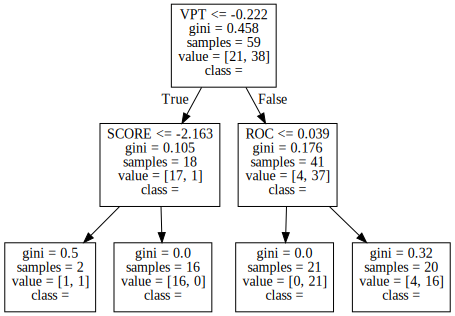

In [1101]:
feature_name = ['ADI','CMF','OBV','ROC','RSI','WR','FI','VPT','SCORE','SENTIMENT']

import graphviz 
dot_data = tree.export_graphviz(clf

                        ,out_file = None ,feature_names=feature_name

                        ,class_names=['涨','跌']) 
graph = graphviz.Source(dot_data) 
graph

### RandomForestClassifier

In [1106]:
regressor = RandomForestClassifier(min_samples_leaf=1
                                   ,min_samples_split=2
                                   ,max_depth=4
                                   ,criterion='entropy'
                                   ,random_state=25)
regressor.fit(x_train, y_train)
regressor.score(x_test, y_test)

0.75

In [1173]:
zoom_new['Randomforestcla']=regressor.predict(x_std)
zoom_new['Randomforestcla return']=1
for i in range(len(zoom_new['Decisiontreecla return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,sentiments,log return,signal,position,Decisiontreecla,Decisiontreecla return,Randomforestcla,Randomforestcla return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,-0.013514,0.010739,1,0,1,1.010739,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,-0.012000,-0.021177,1,1,1,0.989334,1,0.989334
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,-0.017762,0.044193,-1,0,1,1.033056,1,1.033056
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,-0.009259,0.022220,1,1,1,1.056010,1,1.056010
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,-0.034179,0.009000,1,1,1,1.065514,1,1.065514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,-0.025723,-0.007156,-1,-1,-1,4.203794,-1,3.618037
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,-0.026963,-0.039148,-1,-1,-1,4.368365,-1,3.759677
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,-0.026032,0.047570,-1,-1,-1,4.160563,-1,3.580831
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,-0.019547,0.118131,1,0,1,4.652053,1,4.003836


In [1104]:
import numpy as np 
gini_thresholds = np.linspace(0,0.5,5)
parameters = {'criterion':("gini","entropy") 
              ,"max_depth":[*range(1,6)] 
              ,'min_samples_leaf':[*range(1,50,5)] }

rfc = RandomForestClassifier(random_state=25) 
GS = GridSearchCV(rfc, parameters, cv=10) 
GS.fit(x_train,y_train)
print(GS.best_params_)
GS.best_score_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}


0.9099999999999999

## ExtraTreesClassifier

In [1114]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(criterion='entropy' ,max_depth=5,
    min_samples_split=18, random_state=25,min_samples_leaf=1)
etc.fit(x_train, y_train)
etc.score(x_test, y_test)

0.6

In [1174]:
zoom_new['ExtraTreescla']=etc.predict(x_std)
zoom_new['ExtraTreescla return']=1
for i in range(len(zoom_new['Decisiontreecla return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,sentiments,log return,signal,position,Decisiontreecla,Decisiontreecla return,Randomforestcla,Randomforestcla return,ExtraTreescla,ExtraTreescla return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,-0.013514,0.010739,1,0,1,1.010739,1,1.010739,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,-0.012000,-0.021177,1,1,1,0.989334,1,0.989334,1,0.989334
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,-0.017762,0.044193,-1,0,1,1.033056,1,1.033056,1,1.033056
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,-0.009259,0.022220,1,1,1,1.056010,1,1.056010,1,1.056010
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,-0.034179,0.009000,1,1,1,1.065514,1,1.065514,1,1.065514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,-0.025723,-0.007156,-1,-1,-1,4.203794,-1,3.618037,1,4.561709
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,-0.026963,-0.039148,-1,-1,-1,4.368365,-1,3.759677,-1,4.740292
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,-0.026032,0.047570,-1,-1,-1,4.160563,-1,3.580831,1,4.965785
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,-0.019547,0.118131,1,0,1,4.652053,1,4.003836,1,5.552396


In [1115]:
cross_val_score(etc, x_train, y_train, cv=10).mean()

0.7766666666666666

In [1111]:
import numpy as np 
gini_thresholds = np.linspace(0,0.5,5)
parameters = {'criterion':("gini","entropy") 
              ,"max_depth":[*range(1,6)] 
              ,'min_samples_leaf':[*range(1,50,5)]
             ,'min_samples_split':[*range(2,20,2)]}

rfc = ExtraTreesClassifier(random_state=25) 
GS = GridSearchCV(rfc, parameters, cv=10) 
GS.fit(x_train,y_train)
print(GS.best_params_)
GS.best_score_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 18}


0.7766666666666666

### KNN and NCA.pipe

In [1117]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

nca = NeighborhoodComponentsAnalysis(random_state=1)
knn = KNeighborsClassifier(n_neighbors=6)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(x_train, y_train)
print(nca_pipe.score(x_test, y_test))

0.7


In [1130]:
nca = NeighborhoodComponentsAnalysis(random_state=1)
nca.fit(x_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))
knn.fit(nca.transform(x_train), y_train)
print(knn.score(nca.transform(x_test), y_test))

0.7
0.7


In [1175]:
zoom_new['knn']=knn.predict(nca.transform(x_std))
zoom_new['knn return']=1
for i in range(len(zoom_new['knn'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,signal,position,Decisiontreecla,Decisiontreecla return,Randomforestcla,Randomforestcla return,ExtraTreescla,ExtraTreescla return,knn,knn return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1,0,1,1.010739,1,1.010739,1,1.010739,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,1,1,1,0.989334,1,0.989334,1,0.989334,1,0.989334
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,-1,0,1,1.033056,1,1.033056,1,1.033056,1,1.033056
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1,1,1,1.056010,1,1.056010,1,1.056010,1,1.056010
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1,1,1,1.065514,1,1.065514,1,1.065514,1,1.065514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,-1,-1,-1,4.203794,-1,3.618037,1,4.561709,-1,3.176530
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,-1,-1,-1,4.368365,-1,3.759677,-1,4.740292,-1,3.300886
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,-1,-1,-1,4.160563,-1,3.580831,1,4.965785,-1,3.143864
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,1,0,1,4.652053,1,4.003836,1,5.552396,1,3.515250


#### nca cross

In [1127]:
nca = cross_val_score(nca_pipe, x_train, y_train, cv=10) 
print(nca.mean())

0.7599999999999999


#### KNN cross

In [1128]:
knn = cross_val_score(knn, x_train, y_train, cv=10) 
print(knn.mean())

0.6066666666666667


### SVM-SVC

In [1140]:
from sklearn.svm import SVC
svc = SVC(C=7,kernel='linear',gamma='auto')
svc.fit(x_train, y_train)
svc.score(x_test, y_test)

0.85

In [1141]:
cross_val_score(svc, x_train, y_train, cv=10).mean()

0.7899999999999999

In [1176]:
zoom_new['SVM']=svc.predict(x_std)
zoom_new['SVM return']=1
for i in range(len(zoom_new['SVM return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,Decisiontreecla,Decisiontreecla return,Randomforestcla,Randomforestcla return,ExtraTreescla,ExtraTreescla return,knn,knn return,SVM,SVM return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1,1.010739,1,1.010739,1,1.010739,1,1.010739,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,1,0.989334,1,0.989334,1,0.989334,1,0.989334,-1,1.032143
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,1,1.033056,1,1.033056,1,1.033056,1,1.033056,1,1.077757
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1,1.056010,1,1.056010,1,1.056010,1,1.056010,1,1.101705
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1,1.065514,1,1.065514,1,1.065514,1,1.065514,1,1.111620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,-1,4.203794,-1,3.618037,1,4.561709,-1,3.176530,-1,3.020362
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,-1,4.368365,-1,3.759677,-1,4.740292,-1,3.300886,-1,3.138604
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,-1,4.160563,-1,3.580831,1,4.965785,-1,3.143864,-1,2.989302
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,1,4.652053,1,4.003836,1,5.552396,1,3.515250,1,3.342430


### GaussianNB

In [1143]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train,y_train)
acc_score = gnb.score(x_test,y_test)
acc_score

0.65

In [1177]:
zoom_new['GaussianNB']=gnb.predict(x_std)
zoom_new['GaussianNB return']=1
for i in range(len(zoom_new['GaussianNB return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,Randomforestcla,Randomforestcla return,ExtraTreescla,ExtraTreescla return,knn,knn return,SVM,SVM return,GaussianNB,GaussianNB return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1,1.010739,1,1.010739,1,1.010739,1,1.010739,1,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,1,0.989334,1,0.989334,1,0.989334,-1,1.032143,-1,1.032143
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,1,1.033056,1,1.033056,1,1.033056,1,1.077757,1,1.077757
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1,1.056010,1,1.056010,1,1.056010,1,1.101705,1,1.101705
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1,1.065514,1,1.065514,1,1.065514,1,1.111620,1,1.111620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,-1,3.618037,1,4.561709,-1,3.176530,-1,3.020362,-1,2.876952
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,-1,3.759677,-1,4.740292,-1,3.300886,-1,3.138604,-1,2.989580
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,-1,3.580831,1,4.965785,-1,3.143864,-1,2.989302,1,3.131793
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,1,4.003836,1,5.552396,1,3.515250,1,3.342430,1,3.501753


In [1145]:
y_pred = gnb.predict(x_test)

In [1146]:
from sklearn.metrics import confusion_matrix as CM 
CM(y_test,y_pred)

array([[5, 5],
       [2, 8]])

# XGBoosting

In [1147]:
from xgboost import XGBRegressor as XGBR 
from sklearn.ensemble import RandomForestRegressor as RFR 
from sklearn.linear_model import LinearRegression as LinearR 
from sklearn.datasets import load_boston 
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS 
from sklearn.metrics import mean_squared_error as MSE

In [1154]:
reg = XGBR(n_estimators=100,random_state=25,objective ='reg:squarederror',reg_alpha=2.85,reg_lambda=0.55,scoring = "neg_mean_squared_error").fit(x_train,y_train) 
reg.score(x_test,y_test)
#reg.feature_importances_

0.22460033050672812

In [1155]:
MSE(y_test,reg.predict(x_test))

0.7753996694932719

In [1156]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train,y_train) 
dtest = xgb.DMatrix(x_test,y_test)
param = {'silent':False,'objective':'reg:linear',"eta":0.1} 
num_round = 180 
bst = xgb.train(param, dtrain, num_round) 
from sklearn.metrics import r2_score 
print(r2_score(y_test,bst.predict(dtest)))
MSE(y_test,bst.predict(dtest))

[18:23:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.17479084625554653


0.8252091537444535

In [1157]:
CVS(reg,x_train,y_train,cv=12).mean()

0.335502637326566

In [1152]:
from sklearn.model_selection import GridSearchCV
param = {"reg_alpha":np.arange(0,5,0.05),"reg_lambda":np.arange(0,2,0.05)}
gscv = GridSearchCV(reg,param_grid = param,scoring = "neg_mean_squared_error")
gscv.fit(x_train,y_train)
print(gscv.best_params_)
gscv.best_score_

{'reg_alpha': 2.85, 'reg_lambda': 0.55}


-0.45945643189009344

In [1178]:
zoom_new['xgboost']=reg.predict(x_std)
zoom_new['xgboost return']=1
for i in range(len(zoom_new['xgboost return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,ExtraTreescla,ExtraTreescla return,knn,knn return,SVM,SVM return,GaussianNB,GaussianNB return,xgboost,xgboost return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1,1.010739,1,1.010739,1,1.010739,1,1.010739,0.698573,1.007502
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,1,0.989334,1,0.989334,-1,1.032143,-1,1.032143,0.660376,0.993412
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,1,1.033056,1,1.033056,1,1.077757,1,1.077757,0.694769,1.023914
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1,1.056010,1,1.056010,1,1.101705,1,1.101705,0.597822,1.037515
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1,1.065514,1,1.065514,1,1.111620,1,1.111620,0.750549,1.044523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,1,4.561709,-1,3.176530,-1,3.020362,-1,2.876952,-0.808487,2.396736
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,-1,4.740292,-1,3.300886,-1,3.138604,-1,2.989580,-0.773442,2.469307
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,1,4.965785,-1,3.143864,-1,2.989302,1,3.131793,-0.825630,2.372325
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,1,5.552396,1,3.515250,1,3.342430,1,3.501753,0.649125,2.554238


In [1159]:
def plot_learning_curve(estimator,title, X, y,

    ax=None, ylim=None, cv=None,  n_jobs=None):

    from sklearn.model_selection import learning_curve 
    import matplotlib.pyplot as plt 
    import numpy as np

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y ,shuffle=True ,cv=cv  ,random_state=420 ,n_jobs=n_jobs) 
    if ax == None:
        ax = plt.gca() 
    else:
        ax = plt.figure() 
    ax.set_title(title) 
    if ylim is not None:
        ax.set_ylim(*ylim) 
    ax.set_xlabel("Training examples") 
    ax.set_ylabel("Score") 
    ax.grid()
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r",label="Training score")

    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g",label="Test score")

    ax.legend(loc="best") 
    return ax

[18:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

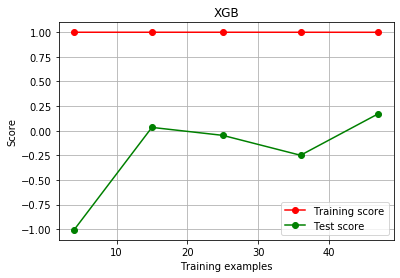

In [1160]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) 
plot_learning_curve(XGBR(n_estimators=100,random_state=42) ,"XGB",x_train,y_train,ax=None,cv=cv) 
plt.show()

In [1180]:
zoom_new['Momentum return']=1
for i in range(len(zoom_new['Momentum return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,12]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,ExtraTreescla return,knn,knn return,SVM,SVM return,GaussianNB,GaussianNB return,xgboost,xgboost return,Momentum return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1.010739,1,1.010739,1,1.010739,1,1.010739,0.698573,1.007502,1.010739
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,0.989334,1,0.989334,-1,1.032143,-1,1.032143,0.660376,0.993412,0.989334
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,1.033056,1,1.033056,1,1.077757,1,1.077757,0.694769,1.023914,0.945612
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1.056010,1,1.056010,1,1.101705,1,1.101705,0.597822,1.037515,0.966623
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1.065514,1,1.065514,1,1.111620,1,1.111620,0.750549,1.044523,0.975323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,4.561709,-1,3.176530,-1,3.020362,-1,2.876952,-0.808487,2.396736,1.735860
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,4.740292,-1,3.300886,-1,3.138604,-1,2.989580,-0.773442,2.469307,1.803816
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,4.965785,-1,3.143864,-1,2.989302,1,3.131793,-0.825630,2.372325,1.718009
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,5.552396,1,3.515250,1,3.342430,1,3.501753,0.649125,2.554238,1.920958


# GBDT

In [1039]:
from sklearn.ensemble import GradientBoostingClassifier
 
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
gbc.score(x_test,y_test)

0.7884615384615384

In [1181]:
zoom_new['GBDT']=reg.predict(x_std)
zoom_new['GBDT return']=1
for i in range(len(zoom_new['GBDT return'])):
    zoom_new.iloc[i,-1]=zoom_new.iloc[i-1,-1]*(zoom_new.iloc[i,-2]*zoom_new.iloc[i,11]+1)
zoom_new

,Adj Close,ADI,CMF,OBV,ROC,RSI,WR,FI,VPT,score,...,knn return,SVM,SVM return,GaussianNB,GaussianNB return,xgboost,xgboost return,Momentum return,GBDT,GBDT return
2020-01-02,68.720001,1.214608e+07,-0.002570,-18231800,0.999413,75.629354,-42.386643,8.945404e+05,3.843923e+04,1.879132e-03,...,1.010739,1,1.010739,1,1.010739,0.698573,1.007502,1.010739,0.698573,1.007502
2020-01-03,67.279999,1.127517e+07,-0.015715,-19359700,-2.095463,47.461530,-88.607589,-1.624179e+06,-1.048746e+04,-5.655787e-03,...,0.989334,-1,1.032143,-1,1.032143,0.660376,0.993412,0.989334,0.660376,0.993412
2020-01-06,70.320000,1.419122e+07,0.065858,-16208100,4.518432,74.351010,-3.736981,9.580867e+06,1.187682e+05,4.417463e-02,...,1.033056,1,1.077757,1,1.077757,0.694769,1.023914,0.945612,0.694769,1.023914
2020-01-07,71.900002,1.739497e+07,0.265467,-9222700,2.246874,81.066281,-27.068231,1.103694e+07,2.993560e+05,-4.380246e-07,...,1.056010,1,1.101705,1,1.101705,0.597822,1.037515,0.966623,0.597822,1.037515
2020-01-08,72.550003,1.825170e+07,0.247902,-6740400,0.904035,83.443921,-32.743237,1.613499e+06,1.793940e+05,4.845887e-02,...,1.065514,1,1.111620,1,1.111620,0.750549,1.044523,0.975323,0.750549,1.044523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,148.990005,7.933929e+07,0.057603,97114000,-0.713043,71.387123,-89.089721,-1.200392e+07,-9.507230e+04,-1.774003e-02,...,3.176530,-1,3.020362,-1,2.876952,-0.808487,2.396736,1.735860,-0.808487,2.396736
2020-04-21,143.270004,7.544736e+07,-0.005709,87404900,-3.839185,47.944065,-70.042686,-5.553606e+07,-4.527444e+05,-2.938748e-02,...,3.300886,-1,3.138604,-1,2.989580,-0.773442,2.469307,1.803816,-0.773442,2.469307
2020-04-22,150.250000,7.829481e+07,0.069817,93957700,4.871917,66.072057,-28.272992,4.573852e+07,-5.350329e+04,-1.326146e-02,...,3.143864,-1,2.989302,1,3.131793,-0.825630,2.372325,1.718009,-0.825630,2.372325
2020-04-23,169.089996,9.865565e+07,0.169111,116117500,12.539099,84.942781,-4.059064,4.174906e+08,3.097886e+06,-1.184353e-02,...,3.515250,1,3.342430,1,3.501753,0.649125,2.554238,1.920958,0.649125,2.554238


# Plot

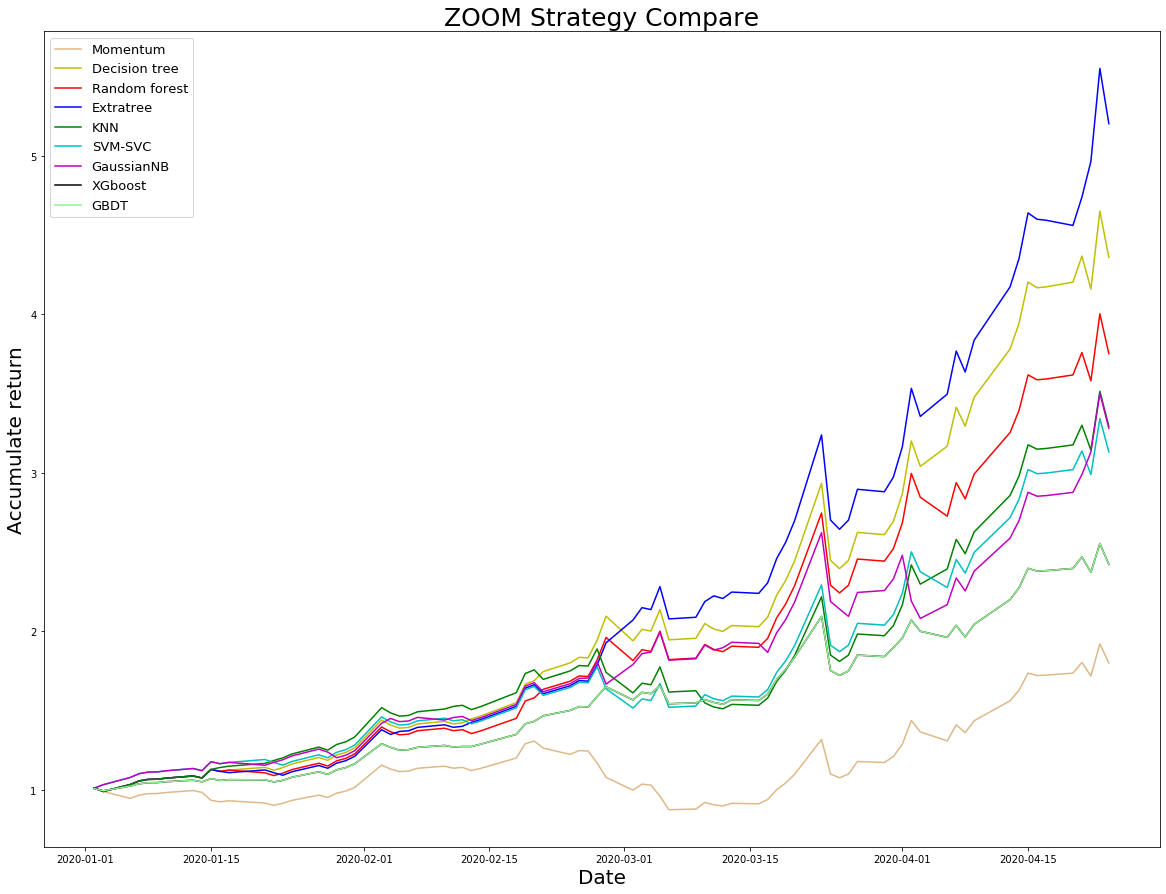

In [1183]:
plt.figure(figsize=(20, 15))
plt.plot(zoom_new['Momentum return'],  c='#DEB887')   
plt.plot(zoom_new['Decisiontreecla return'], 'y')
plt.plot(zoom_new['Randomforestcla return'],  'r')
plt.plot(zoom_new['ExtraTreescla return'],  'b')
plt.plot(zoom_new['knn return'],  'g')
plt.plot(zoom_new['SVM return'],  'c')
plt.plot(zoom_new['GaussianNB return'],  'm')
plt.plot(zoom_new['xgboost return'],  'k') 
plt.plot(zoom_new['GBDT return'],  c='#90EE90')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Accumulate return', fontsize=20)
plt.title('ZOOM Strategy Compare', fontsize=25)
plt.legend(('Momentum','Decision tree','Random forest','Extratree','KNN','SVM-SVC','GaussianNB','XGboost','GBDT'), fontsize=13, loc='upper left')
plt.show()